In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline
import itertools
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFECV, RFE, SelectKBest, chi2, SelectFromModel
from sklearn.utils import resample

In [2]:
path_project = Path.home() / Path('Google Drive/Felix')
path_data = path_project / Path("data")
path_dump = path_project / Path("dump")

In [3]:
# loading data
file = path_data / Path("dataset.csv")
with Path.open(file, 'rb') as fp:
    dataset = pd.read_csv(fp,  encoding='utf-8',low_memory=False, index_col = 0)

In [4]:
# load feature sets
filename = path_dump / Path("dict_features_sets.sav")
with open(filename, 'rb') as fp:
     dict_features_sets = pickle.load(fp)

usual_common_features = dict_features_sets['usual_common_features']
indiv_act_features = dict_features_sets['indiv_act_features']
indiv_semi_act_features = dict_features_sets['indiv_semi_act_features']
RFE_LogisticRegression_20_features = dict_features_sets['RFE_LogisticRegression_20_features']
#lasso_20_features = dict_features_sets['lasso_20_features']
#lasso_50_features = dict_features_sets['lasso_50_features']
#lasso_100_features = dict_features_sets['lasso_100_features']

In [5]:
df = dataset.loc[:,:]
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

In [6]:
dict_features_sets.keys()

dict_keys(['usual_common_features', 'indiv_act_features', 'indiv_semi_act_features', 'admin_act_features', 'admin_semi_act_features', 'RFE_LinearSVC_100_features', 'RFE_LinearSVC_50_features', 'RFE_LinearSVC_20_features', 'RFE_LinearSVC_10_features', 'RFE_RandomForestClassifier_100_features', 'RFE_RandomForestClassifier_50_features', 'RFE_RandomForestClassifier_20_features', 'RFE_RandomForestClassifier_10_features', 'RFE_LogisticRegression_100_features', 'RFE_LogisticRegression_50_features', 'RFE_LogisticRegression_20_features', 'RFE_LogisticRegression_10_features', 'SelectFromModel_LinearSCV_features', 'SelectFromModel_LogisticRegression_features'])

In [7]:
scope = RFE_LogisticRegression_20_features | indiv_act_features

n_max = 2000
df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
features = df.loc[:,scope ].columns

X = df.loc[:,scope]
y = df["HEUREUX_CLF"]

X, y = resample(X, y, random_state=42)

X = X.iloc[0:n_max,:]
y = y.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 2000
- training set: 1600
- test set: 400
Number of features: p=66
Number of class: 2
class 0 : 35.6%
class 1 : 64.4%


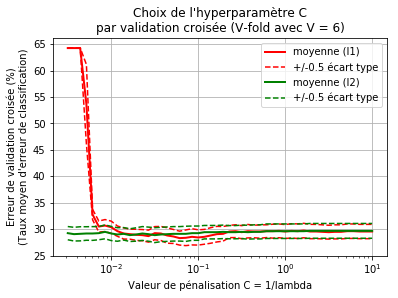

Détermination des paramètres optimaux en 10.6 s
Pénalisation l1, valeur optimale : C = 0.06
Pénalisation l2, valeur optimale : C = 0.03


In [8]:
nb_value = 50 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
mean_score_l2 = np.zeros(nb_value)
C_log = np.logspace(-2.5,1,nb_value)
cv = 6 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

mean_score_l2 = np.empty(nb_value)
std_scores_l2 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', 
                             tol=0.01, random_state=42, 
                             class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train,
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    


for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l2', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l2[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train, 
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l2[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    
    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:],
             'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')

plt.semilogx(C_log,mean_score_l2[:],'g',linewidth=2,label='moyenne (l2)')
plt.semilogx(C_log,mean_score_l2[:]-0.5*std_scores_l2[:], 'g--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l2[:]+0.5*std_scores_l2[:],'g--')

plt.xlabel("Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print("Détermination des paramètres optimaux en %0.1f s" % (time.time() - startTime))
print("Pénalisation l1, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l1)]))
print("Pénalisation l2, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l2)]))

In [9]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l1)], 
                         penalty='l1', 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 70.8 %
- Precision : 81.5 % (Happy # positive class)
- Recall : 71.2 %
- F1 score : 76.0 %


In [10]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l2)], 
                         penalty='l2', 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 70.0 %
- Precision : 81.2 % (Happy # positive class)
- Recall : 70.0 %
- F1 score : 75.2 %


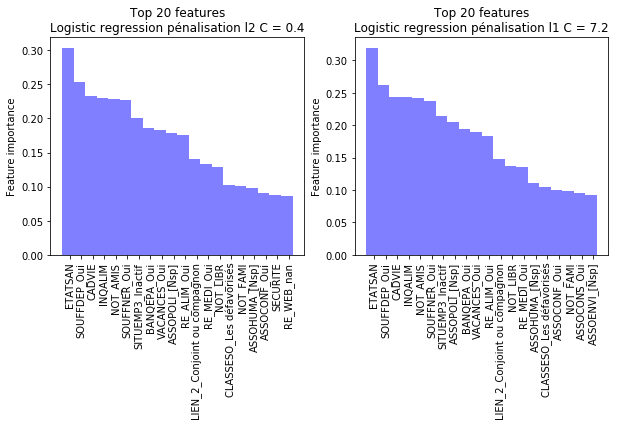

In [11]:
#features = df_tmp.columns.drop(["HEUREUX_CLF"])
# Use regression coefficients to rank features
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l2)], 
                         penalty='l2', 
                         random_state=42, 
                         class_weight='balanced')


clf.fit(X_train,y_train)
coef_l2 = abs(clf.coef_)
coef_sorted_l2 = -np.sort(-coef_l2).reshape(-1)
features_sorded_l2 = np.argsort(-coef_l2).reshape(-1)
features_name = np.array(features)
features_name_sorted_l2 = features_name[features_sorded_l2]
    
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l1)], 
                         penalty='l2', 
                         random_state=42, 
                         class_weight='balanced')
    
clf.fit(X_train,y_train)
coef_l1 = abs(clf.coef_)
coef_sorted_l1 = -np.sort(-coef_l1).reshape(-1)
features_sorded_l1 = np.argsort(-coef_l1).reshape(-1)
features_name_sorted_l1 = features_name[features_sorded_l1]

nf = min(X_train.shape[1],20)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ind = np.arange(nf)    # the x locations for the groups

plt.subplot(1, 2, 1)
p1 = plt.bar(ind, coef_sorted_l2[0:nf], 1, color='b',alpha=0.5)
plt.ylabel('Feature importance')
plt.title(u'Top %i features\nLogistic regression pénalisation l2 C = 0.4' % nf)
plt.xticks(ind + 0.35/2.0, features_name_sorted_l2[0:nf], rotation = 90)

plt.subplot(1, 2, 2)
p1 = plt.bar(ind, coef_sorted_l1[0:nf], 1, color='b',alpha=0.5)
plt.ylabel('Feature importance')
plt.title(u'Top %i features\nLogistic regression pénalisation l1 C = 7.2' % nf)
plt.xticks(ind + 0.35/2.0, features_name_sorted_l1[0:nf], rotation = 90)

plt.show()

In [12]:
for i,feature in enumerate(features_name_sorted_l1):
    if i < 20:
        if feature in indiv_act_features:
            print(f"acionate {feature}, {coef_l1[abs(coef_l1) == coef_sorted_l1[i]][0]:0.4f}")

acionate NOT_AMIS, 0.2427
acionate ASSOPOLI_[Nsp], 0.2053
acionate VACANCES_Oui, 0.1901
acionate NOT_LIBR, 0.1371
acionate ASSOHUMA_[Nsp], 0.1102
acionate ASSOCONF_Oui, 0.1003
acionate NOT_FAMI, 0.0988
acionate ASSOCONS_Oui, 0.0949
acionate ASSOENVI_[Nsp], 0.0919


### RFE ...on scope

Optimal number of features : 15


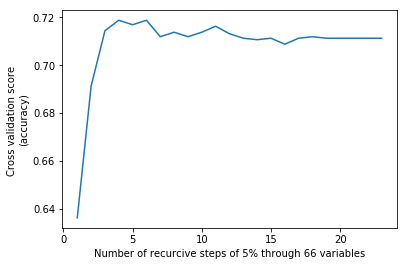

Détermination des features optimales en 1.2 s


In [13]:
startTime = time.time()

scoring='accuracy' 
step = 0.05

clf = LogisticRegression(C=1, 
                         penalty='l1', 
                         class_weight='balanced',
                         random_state=42)

rfecv = RFECV(estimator=clf, step=step, cv=StratifiedKFold(4),
              scoring=scoring)

rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel(f"Number of recurcive steps of {100*step:0.0f}% through {X_train.shape[1]} variables")
plt.ylabel(f"Cross validation score \n({scoring})")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print(f"Détermination des features optimales en %0.1f s" % (time.time() - startTime))

In [14]:
mask = rfecv.support_.copy()
X_train = X_train[:,mask]
X_test = X_test[:,mask]
print(f"Number of features: p={X_train.shape[1]}")

Number of features: p=15


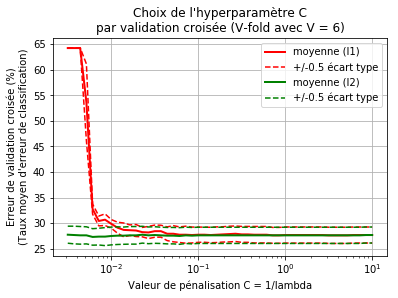

Détermination des paramètres optimaux en 5.2 s
Pénalisation l1, valeur optimale : C = 0.72
Pénalisation l2, valeur optimale : C = 0.01


In [15]:
nb_value = 50 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
mean_score_l2 = np.zeros(nb_value)
C_log = np.logspace(-2.5,1,nb_value)
cv = 6 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

mean_score_l2 = np.empty(nb_value)
std_scores_l2 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', 
                             tol=0.01, random_state=42, 
                             class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train,
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    


for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l2', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l2[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train, 
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l2[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    
    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:],
             'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')

plt.semilogx(C_log,mean_score_l2[:],'g',linewidth=2,label='moyenne (l2)')
plt.semilogx(C_log,mean_score_l2[:]-0.5*std_scores_l2[:], 'g--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l2[:]+0.5*std_scores_l2[:],'g--')

plt.xlabel("Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print("Détermination des paramètres optimaux en %0.1f s" % (time.time() - startTime))
print("Pénalisation l1, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l1)]))
print("Pénalisation l2, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l2)]))

In [16]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l1)], 
                         penalty='l1', 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 71.0 %
- Precision : 81.9 % (Happy # positive class)
- Recall : 71.2 %
- F1 score : 76.1 %


In [17]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l2)], 
                         penalty='l2', 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 70.2 %
- Precision : 81.6 % (Happy # positive class)
- Recall : 70.0 %
- F1 score : 75.4 %


### Model valuation on whole scope

In [18]:
df = dataset.loc[:,:]
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

scope = RFE_LogisticRegression_20_features | indiv_act_features

n_max = 2000
df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
features = df.loc[:,scope ].columns

X = df.loc[:,scope]
y = df["HEUREUX_CLF"]

X, y = resample(X, y, random_state=42)

X = X.iloc[0:n_max,:]
y = y.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 2000
- training set: 1600
- test set: 400
Number of features: p=66
Number of class: 2
class 0 : 35.6%
class 1 : 64.4%


#### Random forest

In [19]:
startTime = time.time()
n_estimators_range = [32,64,128,256,512]
max_depth_range = [4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)

params = {'max_features' :'sqrt', 'random_state' : 32,
          'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"Random Forest, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Determination of optimal hyperparameters in 38.6 s
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
Accuracy Score of cross valdation 75.19%
Random Forest, p=66
Model score
- Accuracy : 79.2 %
- Precision : 80.4 % (Happy # positive class)
- Recall : 90.0 %
- F1 score : 84.9 %


#### SVM - Linear kernel

In [20]:
X_train.shape

(1600, 66)

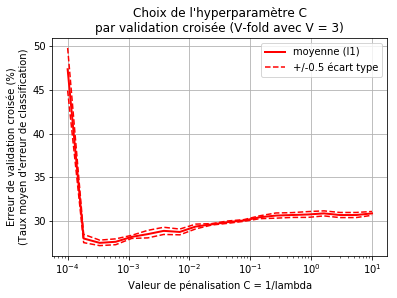

Determination of optimal hyperparameters in 37.1 s
Valeur optimale : C = 0.0003
SCV linear kernel, p=66
Model score
- Accuracy : 73.8 %
- Precision : 79.7 % (Happy # positive class)
- Recall : 80.0 %
- F1 score : 79.8 %


In [21]:
nb_value = 20 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_svc = np.zeros(nb_value)
C_log = np.logspace(-4,1,nb_value)
cv = 3 # V-fold, nombre de fold

mean_score_svc = np.empty(nb_value)
std_scores_svc = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = SVC(C=C,
              kernel = 'linear',
              random_state=42, 
              class_weight='balanced')
    
    mean_score_svc[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train,
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_svc[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    


plt.figure()
plt.semilogx(C_log,mean_score_svc[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_svc[:]-0.5*std_scores_svc[:],
             'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_svc[:]+0.5*std_scores_svc[:],'r--')

plt.xlabel("Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print("Valeur optimale : C = %0.4f" % (C_log[np.argmin(mean_score_svc)]))



# Learning on full training set with optimals hyperparameters and score on test set
params = {
    'C' : C_log[np.argmin(mean_score_svc)],
    'random_state' : 32, 
    'kernel' : 'linear',
    'class_weight' : 'balanced'
}
clf = SVC(**params).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"SCV linear kernel, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Optimal number of features : 33


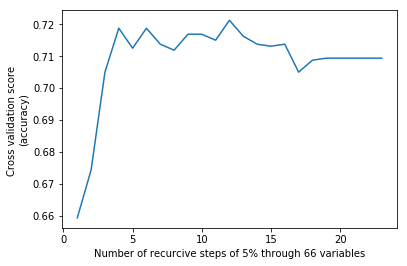

Détermination des features optimales en 25.0 s


In [22]:
startTime = time.time()

scoring='accuracy' 
step = 0.05

clf = SVC(C=1,
          kernel = 'linear',
          random_state=42, 
          class_weight='balanced')

rfecv = RFECV(estimator=clf, step=step, cv=StratifiedKFold(4),
              scoring=scoring)

rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel(f"Number of recurcive steps of {100*step:0.0f}% through {X_train.shape[1]} variables")
plt.ylabel(f"Cross validation score \n({scoring})")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print(f"Détermination des features optimales en %0.1f s" % (time.time() - startTime))

In [23]:
mask = rfecv.support_.copy()
X_train = X_train[:,mask]
X_test = X_test[:,mask]
print(f"Number of features: p={X_train.shape[1]}")

Number of features: p=33


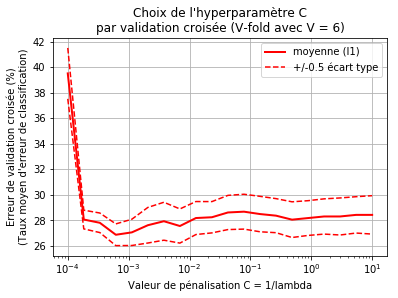

Determination of optimal hyperparameters in 56.8 s
Valeur optimale : C = 0.0006
SCV linear kernel, p=33
Model score
- Accuracy : 73.8 %
- Precision : 80.4 % (Happy # positive class)
- Recall : 78.8 %
- F1 score : 79.6 %


In [24]:
nb_value = 20 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_svc = np.zeros(nb_value)
C_log = np.logspace(-4,1,nb_value)
cv = 6 # V-fold, nombre de fold

mean_score_svc = np.empty(nb_value)
std_scores_svc = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = SVC(C=C,
              kernel = 'linear',
              random_state=42, 
              class_weight='balanced')
    
    mean_score_svc[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train,
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_svc[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    


plt.figure()
plt.semilogx(C_log,mean_score_svc[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_svc[:]-0.5*std_scores_svc[:],
             'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_svc[:]+0.5*std_scores_svc[:],'r--')

plt.xlabel("Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print("Valeur optimale : C = %0.4f" % (C_log[np.argmin(mean_score_svc)]))



# Learning on full training set with optimals hyperparameters and score on test set
params = {
    'C' : C_log[np.argmin(mean_score_svc)],
    'random_state' : 32, 
    'kernel' : 'linear',
    'class_weight' : 'balanced'
}
clf = SVC(**params).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"SCV linear kernel, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

### Model valuation by cluster

In [25]:
df = dataset.loc[:,:]
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

scope = RFE_LogisticRegression_20_features | indiv_act_features
n_max = 12000
df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
features = df.loc[:,scope ].columns

X = df.loc[:,scope]
y = df["HEUREUX_CLF"]

X, y = resample(X, y, random_state=42)

X = X.iloc[0:n_max,:]
y = y.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10674
- training set: 8539
- test set: 2135
Number of features: p=66
Number of class: 2
class 0 : 34.3%
class 1 : 65.7%


In [26]:
# loading cdv data
file = path_data / Path("clustTest1.csv")
with Path.open(file, 'rb') as fp:
    clustTest1 = pd.read_csv(fp,  encoding='utf-8',low_memory=False, sep=";", index_col = 0)

In [27]:
#score = dict()

n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }

score_clustering_methods = []
clustering_methods = clustTest1.columns[0:3]

for method in clustering_methods:
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print(f"cluster {cluster} : {len(index_scope)} elements")
        
        # treating remaining missing values        
        n_max = 2000
        df_tmp = df.loc[index_scope,RFE_LogisticRegression_20_features | indiv_act_features | {"HEUREUX_CLF"} ].dropna()
        features = df.loc[:,RFE_LogisticRegression_20_features | indiv_act_features ].columns

        X = df_tmp.loc[:,RFE_LogisticRegression_20_features | indiv_act_features]
        y = df_tmp["HEUREUX_CLF"]

        X, y = resample(X, y)

        X = X.iloc[0:n_max,:]
        y = y.iloc[0:n_max]

        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2, 
                                                            random_state=42)

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
                
        
        print(f"Number exemple: {y.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='accuracy', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Optimal values are {grid.best_params_} \n\
        Score of cross valdation {100*grid.best_score_:0.2f}%")

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        f1 = f1_score(y_test, y_test_pred)
        p = precision_score(y_test, y_test_pred)
        r = recall_score(y_test, y_test_pred)            

        res  = {'f1_score' : f1,
                'accuracy' : accuracy,
                'precision' : p,
                'recall' : r}
            
        cl = {'cluster' : cluster,
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res
             }
         
        score_cluster.append(cl)
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d) 


Analysis cluster method clust1
liste of clusters : [1 2 3 4 5 6]
cluster 1 : 295 elements
Number exemple: 271
        - training set: 216
        - test set: 55
Number of features: p=66
Number of class: 2
class 0 : 46.9%
class 1 : 53.1%
Optimal values are {'max_depth': 16, 'n_estimators': 32} 
        Score of cross valdation 80.09%
cluster 2 : 1729 elements
Number exemple: 1691
        - training set: 1352
        - test set: 339
Number of features: p=66
Number of class: 2
class 0 : 38.6%
class 1 : 61.4%
Optimal values are {'max_depth': 32, 'n_estimators': 32} 
        Score of cross valdation 85.65%
cluster 3 : 3633 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=66
Number of class: 2
class 0 : 33.3%
class 1 : 66.7%
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
        Score of cross valdation 79.75%
cluster 4 : 218 elements
Number exemple: 201
        - training set: 160
        - test set: 41
Number of features:

In [28]:
#print(f"F1 on full dataset : {100*score_rf['f1_macro']:0.1f}%")
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']}, f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['f1_score']
    average_score = average_score / (i+1)
    print(f"average f1 on clusters {100*average_score:0.1f}%")  

method clust1:
cluster 1, f1 macro 89.3%
cluster 2, f1 macro 87.1%
cluster 3, f1 macro 90.6%
cluster 4, f1 macro 87.7%
cluster 5, f1 macro 62.5%
cluster 6, f1 macro 100.0%
average f1 on clusters 86.2%
method clust2:
cluster 4, f1 macro 69.0%
cluster 6, f1 macro 91.7%
cluster 5, f1 macro 90.7%
cluster 1, f1 macro 87.1%
cluster 3, f1 macro 91.3%
cluster 2, f1 macro 88.8%
cluster 7, f1 macro 78.6%
average f1 on clusters 85.3%
method clust3:
cluster 5, f1 macro 83.3%
cluster 4, f1 macro 89.8%
cluster 1, f1 macro 85.5%
cluster 2, f1 macro 88.5%
cluster 3, f1 macro 76.2%
average f1 on clusters 84.7%


In [29]:
#print(f"F1 on full dataset : {100*score_rf['f1_macro']:0.1f}%")
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']}, accuracy {100*score_cluster['metrics']['accuracy']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['accuracy']
    average_score = average_score / (i+1)
    print(f"average accuracy on clusters {100*average_score:0.1f}%")  

method clust1:
cluster 1, accuracy 89.1%
cluster 2, accuracy 84.1%
cluster 3, accuracy 86.2%
cluster 4, accuracy 82.9%
cluster 5, accuracy 71.4%
cluster 6, accuracy 100.0%
average accuracy on clusters 85.6%
method clust2:
cluster 4, accuracy 76.9%
cluster 6, accuracy 89.3%
cluster 5, accuracy 86.4%
cluster 1, accuracy 83.6%
cluster 3, accuracy 88.0%
cluster 2, accuracy 84.8%
cluster 7, accuracy 78.4%
average accuracy on clusters 83.9%
method clust3:
cluster 5, accuracy 83.6%
cluster 4, accuracy 86.2%
cluster 1, accuracy 81.5%
cluster 2, accuracy 85.9%
cluster 3, accuracy 76.2%
average accuracy on clusters 82.7%


### Code factorisation...  
Evaluation of LinearSVM, LogisticalRegression, RandomForest on various subset of features

In [30]:
n_features = [100,50,20,10]
models =  ['RFE_LogisticRegression_', 'RFE_RandomForestClassifier_','RFE_LinearSVC_']
keys = [m+str(n)+'_features' for m in models for n in n_features]
keys +=['SelectFromModel_LinearSCV_features','SelectFromModel_LogisticRegression_features']

In [31]:
keys

['RFE_LogisticRegression_100_features',
 'RFE_LogisticRegression_50_features',
 'RFE_LogisticRegression_20_features',
 'RFE_LogisticRegression_10_features',
 'RFE_RandomForestClassifier_100_features',
 'RFE_RandomForestClassifier_50_features',
 'RFE_RandomForestClassifier_20_features',
 'RFE_RandomForestClassifier_10_features',
 'RFE_LinearSVC_100_features',
 'RFE_LinearSVC_50_features',
 'RFE_LinearSVC_20_features',
 'RFE_LinearSVC_10_features',
 'SelectFromModel_LinearSCV_features',
 'SelectFromModel_LogisticRegression_features']

In [32]:
n_max = 2000

for k in keys:
    scope = dict_features_sets[k] | indiv_act_features
    print(f"feature selection methode : {k}")

    
    df = dataset.loc[:,:]
    # reducing problem to a 2 class classification problem
    df["HEUREUX_CLF"] = 0
    df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
    df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
    df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None
    
    
    df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
    features = df.loc[:,scope ].columns

    X = df.loc[:,scope]
    y = df["HEUREUX_CLF"]

    Xs, ys = resample(X, y, random_state=42)

    Xs = Xs.iloc[0:n_max,:]
    ys = ys.iloc[0:n_max]

    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, 
                                                        test_size=0.2, 
                                                        random_state=42)

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

#    print(f"Number exemple: {y.shape[0]}\n- training set: \
#    {y_train.shape[0]}\n- test set: {y_test.shape[0]}")
    print(f"Number of features: p={X_train.shape[1]}")
#    print(f"Number of class: {len(np.unique(y))}")
#    for c in np.unique(y):
#        print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")



    startTime = time.time()
    n_estimators_range = [32,64,128,256,512]
    max_depth_range = [4,8,16,32,64] 
    param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)

    params = {'max_features' :'sqrt', 'random_state' : 32,
              'min_samples_split' : 2, 'class_weight' : 'balanced'}
    clf = RandomForestClassifier(**params)

    grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
    grid.fit(X_train, y_train)
    print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
    print(f"Optimal values are {grid.best_params_} \n\
    Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

    # Learning on full training set with optimals hyperparameters and score on test set
    params = {'max_features' :'sqrt', 'random_state' : 32, 
              'min_samples_split' : 2, 'class_weight' : 'balanced',
              'n_estimators' : grid.best_params_['n_estimators'],
              'max_depth' : grid.best_params_['max_depth']}
    clf = RandomForestClassifier(**params).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)

    print(f"Random Forest, p={X_train.shape[1]}")
    accuracy = clf.score(X_test, y_test)
    f1 = f1_score(y_test, y_test_pred)
    p = precision_score(y_test, y_test_pred)
    r = recall_score(y_test, y_test_pred)
    print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
    print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
    print(f"- Recall : {r*100:0.1f} %")
    print(f"- F1 score : {f1*100:0.1f} %")
    print()


feature selection methode : RFE_LogisticRegression_100_features
Number of features: p=145
Determination of optimal hyperparameters in 54.1 s
Optimal values are {'max_depth': 16, 'n_estimators': 512} 
    Accuracy Score of cross valdation 77.75%
Random Forest, p=145
Model score
- Accuracy : 75.5 %
- Precision : 72.1 % (Happy # positive class)
- Recall : 93.0 %
- F1 score : 81.2 %

feature selection methode : RFE_LogisticRegression_50_features
Number of features: p=95
Determination of optimal hyperparameters in 52.5 s
Optimal values are {'max_depth': 32, 'n_estimators': 256} 
    Accuracy Score of cross valdation 76.00%
Random Forest, p=95
Model score
- Accuracy : 79.8 %
- Precision : 79.5 % (Happy # positive class)
- Recall : 92.7 %
- F1 score : 85.6 %

feature selection methode : RFE_LogisticRegression_20_features
Number of features: p=66
Determination of optimal hyperparameters in 46.8 s
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
    Accuracy Score of cross valdation 7

In [33]:
n_max = 2000

for k in keys:
    scope = dict_features_sets[k] | indiv_act_features
    print(f"feature selection methode : {k}")

    
    df = dataset.loc[:,:]
    # reducing problem to a 2 class classification problem
    df["HEUREUX_CLF"] = 0
    df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
    df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
    df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None
    
    
    df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
    features = df.loc[:,scope ].columns

    X = df.loc[:,scope]
    y = df["HEUREUX_CLF"]

    Xs, ys = resample(X, y, random_state=42)

    Xs = Xs.iloc[0:n_max,:]
    ys = ys.iloc[0:n_max]

    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, 
                                                        test_size=0.2, 
                                                        random_state=42)

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

#    print(f"Number exemple: {y.shape[0]}\n- training set: \
#    {y_train.shape[0]}\n- test set: {y_test.shape[0]}")
    print(f"Number of features: p={X_train.shape[1]}")
#    print(f"Number of class: {len(np.unique(y))}")
#    for c in np.unique(y):
#        print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")



    nb_value = 20 # Nombre de valeurs testées pour l'hyperparamètre
    mean_score_svc = np.zeros(nb_value)
    C_log = np.logspace(-4,1,nb_value)
    cv = 3 # V-fold, nombre de fold

    mean_score_svc = np.empty(nb_value)
    std_scores_svc = np.empty(nb_value)

    np.random.seed(seed=42) 

    startTime = time.time()

    for i, C in enumerate(C_log):
        clf = LinearSVC(C=C,
                        dual = False,
                        random_state=42, 
                        class_weight='balanced')
    
        mean_score_svc[i] = 100*np.mean(1-cross_val_score(clf, 
                                                         X_train, 
                                                         y_train,
                                                         cv=cv, 
                                                         scoring='accuracy'))
        std_scores_svc[i] = 100*np.std(1-cross_val_score(clf, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=cv, 
                                                        scoring='accuracy'))    



    print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
    print("Valeur optimale : C = %0.4f" % (C_log[np.argmin(mean_score_svc)]))



    # Learning on full training set with optimals hyperparameters and score on test set
    params = {
        'C' : C_log[np.argmin(mean_score_svc)],
        'random_state' : 32, 
        'dual' : False,
        'class_weight' : 'balanced'
    }
    clf = LinearSVC(**params).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)

    print(f"SCV linear kernel, p={X_train.shape[1]}")
    accuracy = clf.score(X_test, y_test)
    f1 = f1_score(y_test, y_test_pred)
    p = precision_score(y_test, y_test_pred)
    r = recall_score(y_test, y_test_pred)
    print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
    print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
    print(f"- Recall : {r*100:0.1f} %")
    print(f"- F1 score : {f1*100:0.1f} %")
    print()

feature selection methode : RFE_LogisticRegression_100_features
Number of features: p=145
Determination of optimal hyperparameters in 29.9 s
Valeur optimale : C = 0.0021
SCV linear kernel, p=145
Model score
- Accuracy : 71.2 %
- Precision : 76.0 % (Happy # positive class)
- Recall : 72.4 %
- F1 score : 74.2 %

feature selection methode : RFE_LogisticRegression_50_features
Number of features: p=95
Determination of optimal hyperparameters in 2.5 s
Valeur optimale : C = 0.0006
SCV linear kernel, p=95
Model score
- Accuracy : 72.2 %
- Precision : 82.0 % (Happy # positive class)
- Recall : 73.5 %
- F1 score : 77.5 %

feature selection methode : RFE_LogisticRegression_20_features
Number of features: p=66
Determination of optimal hyperparameters in 1.5 s
Valeur optimale : C = 0.0011
SCV linear kernel, p=66
Model score
- Accuracy : 70.5 %
- Precision : 81.7 % (Happy # positive class)
- Recall : 70.4 %
- F1 score : 75.6 %

feature selection methode : RFE_LogisticRegression_10_features
Number of

### Valuation of the same model family on clusters...

In [34]:
# loading data
file = path_data / Path("dataset_2017_2018.csv")
with Path.open(file, 'rb') as fp:
    dataset_2017_2018 = pd.read_csv(fp,  encoding='utf-8',low_memory=False, index_col = 0)

In [35]:
# loading cdv data
file = path_data / Path("clustTest1.csv")
with Path.open(file, 'rb') as fp:
    clustTest1 = pd.read_csv(fp,  encoding='utf-8',low_memory=False, sep=";", index_col = 0)

#### 1) Full scope 2017-2018 - training set 2000

In [36]:
df = dataset_2017_2018.loc[:,:]
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

scope = ( RFE_LogisticRegression_20_features | indiv_act_features )  & set(dataset_2017_2018.columns)


df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
features = df.loc[:,scope ].columns

X = df.loc[:,scope]
y = df["HEUREUX_CLF"]

n_max = 2000
Xs, ys = resample(X, y, random_state=42)

Xs = Xs.iloc[0:n_max,:]
ys = ys.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 5722
- training set: 1600
- test set: 400
Number of features: p=66
Number of class: 2
class 0 : 36.8%
class 1 : 63.2%


In [37]:
startTime = time.time()
n_estimators_range = [32,64,128,256,512]
max_depth_range = [4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)

params = {'max_features' :'sqrt', 'random_state' : 32,
          'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"Random Forest, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")
res_full  = {
    'f1_score' : f1,
    'accuracy' : accuracy,
    'precision' : p,
    'recall' : r
}

Determination of optimal hyperparameters in 41.1 s
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
Accuracy Score of cross valdation 76.12%
Random Forest, p=66
Model score
- Accuracy : 81.0 %
- Precision : 80.9 % (Happy # positive class)
- Recall : 91.2 %
- F1 score : 85.7 %


#### Estimation on each clusters...

In [38]:
n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }

n_max = 2000

scope = ( RFE_LogisticRegression_20_features | indiv_act_features )  & set(dataset_2017_2018.columns)
features = df.loc[:,scope].columns

In [39]:
score_clustering_methods = []
clustering_methods = clustTest1.columns[0:3]

for method in clustering_methods:
    print("--------------------------------------------")
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print("++++++++++++")
        print(f"cluster {cluster} : {len(index_scope)} elements")
        
        Xc = X.loc[index_scope.intersection(X.index),:]
        yc = y[index_scope.intersection(X.index)]
        
        Xs, ys = resample(Xc, yc, random_state=42)
        
        Xs = Xs.iloc[0:n_max,:]
        ys = ys.iloc[0:n_max]
        
        X_train, X_test, y_train, y_test = train_test_split(Xs, ys,
                                                            test_size=0.2, 
                                                            random_state=42)

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
                
        print(f"Number exemple: {ys.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='accuracy', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Optimal values are {grid.best_params_} \n\
        Score of cross valdation {100*grid.best_score_:0.2f}%")
        print()

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        f1 = f1_score(y_test, y_test_pred)
        p = precision_score(y_test, y_test_pred)
        r = recall_score(y_test, y_test_pred)            

        res  = {'f1_score' : f1,
                'accuracy' : accuracy,
                'precision' : p,
                'recall' : r}
            
        cl = {'cluster' : cluster,
              'size' : len(index_scope),
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res
             }
         
        score_cluster.append(cl)
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d) 

--------------------------------------------

Analysis cluster method clust1
liste of clusters : [1 2 3 4 5 6]
++++++++++++
cluster 1 : 295 elements
Number exemple: 271
        - training set: 216
        - test set: 55
Number of features: p=66
Number of class: 2
class 0 : 36.8%
class 1 : 63.2%
Optimal values are {'max_depth': 8, 'n_estimators': 128} 
        Score of cross valdation 78.70%

++++++++++++
cluster 2 : 1729 elements
Number exemple: 1691
        - training set: 1352
        - test set: 339
Number of features: p=66
Number of class: 2
class 0 : 36.8%
class 1 : 63.2%
Optimal values are {'max_depth': 16, 'n_estimators': 64} 
        Score of cross valdation 86.09%

++++++++++++
cluster 3 : 3633 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=66
Number of class: 2
class 0 : 36.8%
class 1 : 63.2%
Optimal values are {'max_depth': 32, 'n_estimators': 128} 
        Score of cross valdation 81.00%

++++++++++++
cluster 4 : 218

In [40]:
#print(f"F1 on full dataset : {100*score_rf['f1_macro']:0.1f}%")

In [41]:
#print(f"F1 on full dataset : {100*score_rf['f1_macro']:0.1f}%")
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} ({score_cluster['size']}), f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")  
        average_score += score_cluster['metrics']['f1_score']*score_cluster['size']
        total_size += score_cluster['size']
        
    average_score = average_score / total_size
    print(f"average f1 on clusters {100*average_score:0.1f}%\n")  

method clust1:
cluster 1 (295), f1 macro 85.7%
cluster 2 (1729), f1 macro 91.3%
cluster 3 (3633), f1 macro 86.9%
cluster 4 (218), f1 macro 86.7%
cluster 5 (137), f1 macro 69.6%
cluster 6 (24), f1 macro 100.0%
average f1 on clusters 87.8%

method clust2:
cluster 4 (212), f1 macro 90.5%
cluster 6 (1137), f1 macro 90.8%
cluster 5 (750), f1 macro 91.6%
cluster 1 (1257), f1 macro 87.7%
cluster 3 (1254), f1 macro 91.1%
cluster 2 (857), f1 macro 95.2%
cluster 7 (569), f1 macro 86.2%
average f1 on clusters 90.5%

method clust3:
cluster 5 (373), f1 macro 87.5%
cluster 4 (2682), f1 macro 88.8%
cluster 1 (1593), f1 macro 88.7%
cluster 2 (1246), f1 macro 95.6%
cluster 3 (142), f1 macro 88.0%
average f1 on clusters 90.1%



In [42]:
#print(f"F1 on full dataset : {100*score_rf['f1_macro']:0.1f}%")
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} ({score_cluster['size']}) , accuracy {100*score_cluster['metrics']['accuracy']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['accuracy']*score_cluster['size']
        total_size += score_cluster['size']
    average_score = average_score / total_size
    print(f"average accuracy on clusters {100*average_score:0.1f}%\n")  

method clust1:
cluster 1 (295) , accuracy 85.5%
cluster 2 (1729) , accuracy 88.2%
cluster 3 (3633) , accuracy 80.8%
cluster 4 (218) , accuracy 80.5%
cluster 5 (137) , accuracy 66.7%
cluster 6 (24) , accuracy 100.0%
average accuracy on clusters 82.9%

method clust2:
cluster 4 (212) , accuracy 89.7%
cluster 6 (1137) , accuracy 87.9%
cluster 5 (750) , accuracy 88.4%
cluster 1 (1257) , accuracy 85.9%
cluster 3 (1254) , accuracy 87.6%
cluster 2 (857) , accuracy 93.3%
cluster 7 (569) , accuracy 86.5%
average accuracy on clusters 88.2%

method clust3:
cluster 5 (373) , accuracy 86.3%
cluster 4 (2682) , accuracy 85.8%
cluster 1 (1593) , accuracy 85.4%
cluster 2 (1246) , accuracy 93.8%
cluster 3 (142) , accuracy 85.7%
average accuracy on clusters 87.3%



In [43]:
res_full

{'accuracy': 0.81000000000000005,
 'f1_score': 0.8571428571428571,
 'precision': 0.80851063829787229,
 'recall': 0.91200000000000003}